In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from utils import *
#from utils_cpdir import *
from utils_mvcp import *
import os

In [4]:
path = 'data/'
files = os.listdir(path)[1:]
data_list = []
for f in files:
    data_ = pd.read_csv(path+f, header=None)
    data_.columns = ['x_'+str(i) for i in range(data_.shape[1])]
    data_['y'] = np.repeat(np.arange(0,10), 200)
    data_list.append(data_)

In [5]:
files

['mfeat-zer_2.csv',
 'mfeat-fou_2.csv',
 'mfeat-mor_2.csv',
 'mfeat-pix_2.csv',
 'mfeat-kar_2.csv',
 'mfeat-fac_2.csv']

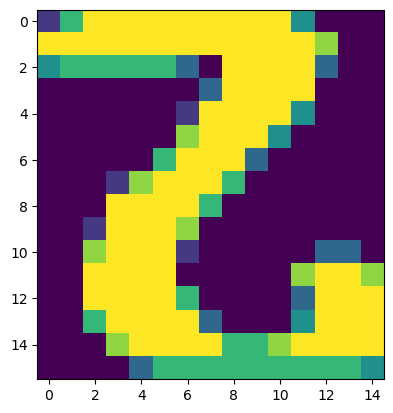

In [6]:
plt.imshow(np.array(data_list[3].iloc[401,:-1]).reshape(16,15))

In [7]:
y = np.array(data_list[0].iloc[:,-1])
seed = 0
train_prop = 0.08
adapt = True
n = int(y.shape[0] * train_prop) 
idx = np.array([1] * n + [0] * (y.shape[0]-n)) > 0
np.random.seed(seed)
np.random.shuffle(idx)
X_train_list = []
X_test_list = []
f_list = []
score_list = []
acc_list = []
y_train, y_test = y[idx], y[~idx]
for d in data_list:
    
    X = np.array(d.iloc[:,:-1])
    X = (X - X.mean(0)) / X.std(0)
    
    X_train, X_test = X[idx,:], X[~idx,:]
    #X_train_list.append(X_train)
    #X_test_list.append(X_test)
    
    clf_ = LogisticRegression(multi_class='multinomial')
    _ = clf_.fit(X_train, y_train)
    #print(clf_.score(X_test, y_test))
    f = clf_.predict_proba(X_test)
    f_list.append(f)
    if adapt:
        cal_pi = f.argsort(1)[:,::-1]
        cal_srt = np.take_along_axis(f,cal_pi,axis=1)
        s = np.array([cal_srt.cumsum(axis=1)[i,cal_pi.argsort(1)[i]] for i in range(f.shape[0])])
    else:
        s = f
            
    score_list.append(s)
    acc_list.append(clf_.score(X_test, y_test))

s_pre_fused = []
f_pf_list = (np.cumsum(f_list,0).transpose(1,2,0)*np.arange(1,7)).transpose(2,0,1)
#f_pf = np.mean(f_list,0) #f_list

for i in range(len(data_list)):
    #f_pf = f_pf_list[i]
    f_pf = np.mean(f_list[:(i+2)],0)
    cal_pi = f_pf.argsort(1)[:,::-1]
    cal_srt = np.take_along_axis(f_pf,cal_pi,axis=1)
    s_pre_fused.append(np.array([cal_srt.cumsum(axis=1)[i,cal_pi.argsort(1)[i]] for i in range(f_pf.shape[0])]))


/Users/eochoa/opt/anaconda3/envs/working/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
d = 120
d_v = 80
K = 6
N = 3000
L = 15
train_prop = .3
N_train = int(N * train_prop)
scale = 3

alpha = .1

set_size = defaultdict(list)
cov = defaultdict(list)
cov_cal = defaultdict(list)
names = [#'full2', 'full3', 'full4', 'full5', 'full6',
             'view2', 'view3', 'view4',  'view5', 'view6',
             'avg2', 'avg3', 'avg4', 'avg5', 'avg6', 
             'norm2','norm3','norm4','norm5','norm6',
             #'pre_fused2', 'pre_fused3', 'pre_fused4',  'pre_fused5', 'pre_fused6',
        ]
seed = 0
#s1, s2, s3, y_train, y_test = simulate_s(N, d, .5, .5, scale, K, N_train, seed)

for i in range(10):
        
    seed = seed + i
    
    #score_list, y_train, y_test, top_views = simulate_s_2(N, d, d_v, L, scale, K, N_train, seed)
    top_views = np.array(acc_list)
    quant_smx_list = []
    rest_smx_list = []
    cal_smx_list = []
    val_smx_list = []
        
    U_list = gen_u(K, seed=seed)
    
    for j in range(K):
    
        quant_smx, rest_smx, quant_labels, rest_labels, idx_quant = split_cal_test(score_list[j], y_test, cal_prop=0.2, seed=seed)
        cal_smx, val_smx, cal_labels, val_labels, idx = split_cal_test(rest_smx, rest_labels, cal_prop=0.8, seed=seed)
        
        quant_smx_list.append(quant_smx)
        rest_smx_list.append(rest_smx)
        cal_smx_list.append(cal_smx)
        val_smx_list.append(val_smx)
        
    n = cal_labels.shape[0]
    
    for j in range(1,K):
        
        prediction_sets, empirical_coverage = mvcp_2(quant_smx_list[:(j+1)],
                                                     quant_labels,
                                                     cal_smx_list[:(j+1)], 
                                                     cal_labels, 
                                                     val_smx_list[:(j+1)], 
                                                     alpha, 
                                                     val_labels, 
                                                     U=U_list[j-1])
    
        set_size['mvcp'+str(j+1)].append(
            prediction_sets.sum(1).mean()
        )
        cov['mvcp'+str(j+1)].append(
            empirical_coverage
        )
        
        s_u = rest_smx_list[:(j+1)][np.argmax(top_views[:(j+1)])]
        #print(top_views[:(j+1)])
        #print(np.argmax(top_views[:(j+1)]))
        
        cal_smx, val_smx, cal_labels, val_labels, idx = split_cal_test(s_u, rest_labels, cal_prop=0.8, seed=seed)
        n = cal_smx.shape[0]
        (prediction_sets, empirical_coverage), qhat = conform_prediction(cal_smx, val_smx, cal_labels, n, alpha, val_labels, cond=0)
        set_size['view'+str(j+1)].append(prediction_sets.sum(1).mean())
        cov['view'+str(j+1)].append(empirical_coverage)
        
        s_u = np.sum(rest_smx_list[:(j+1)], 0)
        
        cal_smx, val_smx, cal_labels, val_labels, idx = split_cal_test(s_u, rest_labels, cal_prop=0.8, seed=seed)
        n = cal_smx.shape[0]
        (prediction_sets, empirical_coverage), qhat = conform_prediction(cal_smx, val_smx, cal_labels, n, alpha, val_labels, cond=0)
        set_size['sum'+str(j+1)].append(prediction_sets.sum(1).mean())
        cov['sum'+str(j+1)].append(empirical_coverage)
        
        s_u = np.power(rest_smx_list[:(j+1)],2).sum(0)
        
        cal_smx, val_smx, cal_labels, val_labels, idx = split_cal_test(s_u, rest_labels, cal_prop=0.8, seed=seed)
        n = cal_smx.shape[0]
        (prediction_sets, empirical_coverage), qhat = conform_prediction(cal_smx, val_smx, cal_labels, n, alpha, val_labels, cond=0)
        set_size['norm'+str(j+1)].append(prediction_sets.sum(1).mean())
        cov['norm'+str(j+1)].append(empirical_coverage)
        
        #s_u = 1/(np.array([1+(np.argmax(score_list[:-1], 2)[:,~idx_quant]==l).mean(0) for l in range(L)]).T)  
        #s_u = 1-np.product(score_list[:(j+1)], 0)[~idx_quant,] ** (1/(j+1))
        #s_u = np.power(rest_smx_list[:(j+1)],2).sum(0)
        #s_u = 1-np.max(score_list[:-1], 0)[~idx_quant,]
        #s_u = np.max(rest_smx_list[:(j+1)], 0)
        s_u = s_pre_fused[j-1][~idx_quant,:]
        
        cal_smx, val_smx, cal_labels, val_labels, idx = split_cal_test(s_u, rest_labels, cal_prop=0.8, seed=seed)
        n = cal_smx.shape[0]
        (prediction_sets, empirical_coverage), qhat = conform_prediction(cal_smx, val_smx, cal_labels, n, alpha, val_labels, cond=0)
        set_size['pre_fused'+str(j+1)].append(prediction_sets.sum(1).mean())
        cov['pre_fused'+str(j+1)].append(empirical_coverage)


0
5


In [70]:
df_res = pd.DataFrame(pd.DataFrame(set_size).mean()).reset_index()
df_res['cp'] = [s[:-1] for s in df_res['index']]
df_res['M'] = [s[-1] for s in df_res['index']]
del df_res['index']
df_res = df_res.pivot(index='M', columns='cp', values=0).loc[:,['view','pre_fused','sum','norm', 'mvcp']]
df_res

cp,view,pre_fused,sum,norm,mvcp
M,,,,,
2,3.389153,3.692203,3.517966,3.514237,2.684746
3,3.389153,3.477288,2.968814,2.945085,1.841017
4,3.282034,3.423051,2.870508,2.830508,1.641695
5,3.282034,3.122373,2.727797,2.679322,1.554576
6,3.191525,3.068475,2.705085,2.638983,1.596949


In [71]:
print(df_res.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
)) 

\begin{tabular}{rrrrr}
\toprule
 view &  pre\_fused &  sum &  norm &  mvcp \\
 3.39 &       3.69 & 3.52 &  3.51 &  2.68 \\
\midrule
 3.39 &       3.48 & 2.97 &  2.95 &  1.84 \\
 3.28 &       3.42 & 2.87 &  2.83 &  1.64 \\
 3.28 &       3.12 & 2.73 &  2.68 &  1.55 \\
 3.19 &       3.07 & 2.71 &  2.64 &  1.60 \\
\bottomrule
\end{tabular}



/var/folders/9g/bj6gc6z17_1fyb7lx57xf04m0000gs/T/ipykernel_66059/2737531582.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_res.to_latex(index=False,


In [72]:
df_res = pd.DataFrame(pd.DataFrame(set_size).std()).reset_index()
df_res['cp'] = [s[:-1] for s in df_res['index']]
df_res['M'] = [s[-1] for s in df_res['index']]
del df_res['index']
df_res = df_res.pivot(index='M', columns='cp', values=0).loc[:,['view','pre_fused','sum','norm', 'mvcp']]
df_res

cp,view,pre_fused,sum,norm,mvcp
M,,,,,
2,0.090829,0.107134,0.127797,0.126109,0.166903
3,0.090829,0.088075,0.086510,0.089555,0.098278
4,0.144065,0.052559,0.049994,0.047188,0.115896
5,0.144065,0.073079,0.076804,0.069859,0.061376
6,0.170320,0.110663,0.061724,0.052302,0.071811


In [73]:
print(df_res.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
)) 

\begin{tabular}{lrrrrr}
\toprule
cp &  view &  pre\_fused &  sum &  norm &  mvcp \\
M &       &            &      &       &       \\
\midrule
2 &  0.09 &       0.11 & 0.13 &  0.13 &  0.17 \\
3 &  0.09 &       0.09 & 0.09 &  0.09 &  0.10 \\
4 &  0.14 &       0.05 & 0.05 &  0.05 &  0.12 \\
5 &  0.14 &       0.07 & 0.08 &  0.07 &  0.06 \\
6 &  0.17 &       0.11 & 0.06 &  0.05 &  0.07 \\
\bottomrule
\end{tabular}



/var/folders/9g/bj6gc6z17_1fyb7lx57xf04m0000gs/T/ipykernel_66059/361595659.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_res.to_latex(index=True,


In [74]:
df_res = pd.DataFrame(pd.DataFrame(cov).mean()).reset_index()
df_res['cp'] = [s[:-1] for s in df_res['index']]
df_res['M'] = [s[-1] for s in df_res['index']]
del df_res['index']
df_res = df_res.pivot(index='M', columns='cp', values=0).loc[:,['view','pre_fused','sum','norm', 'mvcp']]
df_res

cp,view,pre_fused,sum,norm,mvcp
M,,,,,
2,0.896610,0.908136,0.906441,0.907119,0.899661
3,0.896610,0.897627,0.898305,0.898644,0.897966
4,0.905085,0.904068,0.902712,0.903390,0.901356
5,0.905085,0.908136,0.906102,0.904068,0.901695
6,0.895932,0.905763,0.904407,0.904407,0.907797


In [75]:
print(df_res.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
)) 

\begin{tabular}{lrrrrr}
\toprule
cp &  view &  pre\_fused &  sum &  norm &  mvcp \\
M &       &            &      &       &       \\
\midrule
2 &  0.90 &       0.91 & 0.91 &  0.91 &  0.90 \\
3 &  0.90 &       0.90 & 0.90 &  0.90 &  0.90 \\
4 &  0.91 &       0.90 & 0.90 &  0.90 &  0.90 \\
5 &  0.91 &       0.91 & 0.91 &  0.90 &  0.90 \\
6 &  0.90 &       0.91 & 0.90 &  0.90 &  0.91 \\
\bottomrule
\end{tabular}



/var/folders/9g/bj6gc6z17_1fyb7lx57xf04m0000gs/T/ipykernel_66059/361595659.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_res.to_latex(index=True,
